Low-earth satellites, such as Starlink constellation launched by SpaceX, have the potential to significantly affect Rubin Observatory’s Legacy Survey of Space and Time. When a satellite crosses the Rubin field of view during an exposure, it leaves a bright trail that can even saturate pixels. The presence of trails affects ability to detect objects and measure their properties and can introduce systematic effects that can limit scientific analysis. In order to quantitatively assess the magnitude of this problem, high-fidelity simulations of satellite constellations are required. 

This code can generate a user-specified satellite constellation, including the motion of all satellites, and find all CCDs and pixels in the LSST field-of view that a trail intersects, provided the location and duration of an LSST exposure. Users can specify input parameters through a simple API, as shown below.


Currently implemented constellation is simulated StarLink -- satellite orbits (altitudes, inclinations, num of planes and satellites per plane) are provided, and initial positions of the satellites (within defined orbits) are randomly generated. The base setup constructs k=11927 satellites.

To add more satellites, API provides sat_mult input parameter. For StarLink this parameter results in direct scaling of the base satellites (altitudes, inclinations, num of planes and sat per plane are extended sat_mult times; see strlnk_constellation.py). For example, sat_mult=2 "produces" 23854 satellites, sat_mult=8 95416 and so on.


In [11]:
from satellite_traces import get_image, get_traces
import numpy as np

14 0.43599470655642586 190832


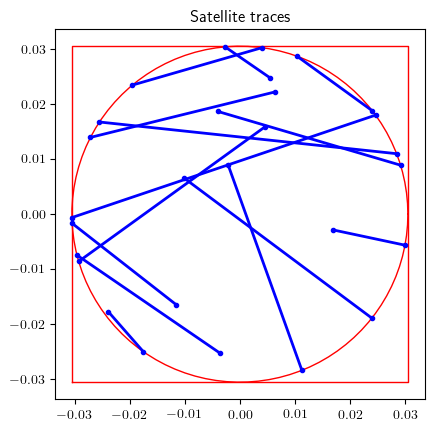

In [2]:
observation_time_mjd=59863.0097259146
epoch=22050.1

# find traces within field of view
num_traces, len_traces, N_sat = get_image(observation_time_mjd, epoch, observation_az=150., observation_alt=20., sat_mult = 16, camera_mode='traces', plot_image=True)
print(num_traces, len_traces, N_sat)

99 52.38095238095238 14 0.43599470655642586 190832


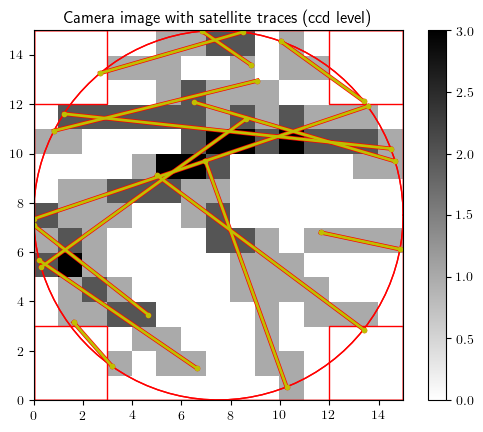

In [3]:
# find traces overlapping CCDs
num_ccd, perc_ccd, traces_per_ccd, ccd_id, num_traces, len_traces, N_sat = get_image(observation_time_mjd, epoch, observation_az=150., observation_alt=20., sat_mult = 16, camera_mode='ccd', plot_image=True)
print(num_ccd, perc_ccd, num_traces, len_traces, N_sat)


In [4]:
# print number of traces per CCD, and CCD ID. 
# ID's start from lower left corner (coordinate [3,0]), and continue sequentially in a row-style fashion (ID 8 is at [11,0], 9 at [3,1] etc)
print(np.vstack((ccd_id,traces_per_ccd)))

[[  7   9  11  12  15  16  19  20  24  28  29  30  31  36  38  39  40  43
   44  45  50  51  52  53  57  58  59  65  66  67  72  73  74  79  80  81
   83  84  85  86  87  88  89  90  93  94 103 104 105 106 107 108 109 121
  122 123 124 130 131 132 133 138 139 140 141 142 143 144 145 146 148 149
  150 151 152 153 154 155 156 157 158 159 160 164 165 166 167 168 171 172
  173 176 178 179 182 183 184 185 187]
 [  1   1   1   1   1   1   1   1   1   1   1   2   2   1   1   1   1   1
    2   1   1   1   1   1   2   3   1   1   1   1   1   2   1   2   2   1
    1   1   1   1   2   1   1   1   1   2   1   1   2   2   2   1   1   1
    3   3   2   1   1   1   1   2   3   3   2   3   2   2   2   1   2   2
    2   2   2   2   1   2   1   2   1   1   1   1   2   1   1   1   1   1
    1   1   1   1   1   1   2   2   1]]


17658075 0.5948317766422566 99 52.38095238095238 14 0.43599470655642586 190832


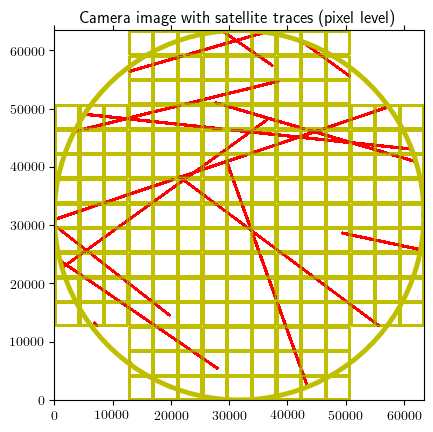

In [5]:
# find traces with width of 50 (pixels) overlapping PIXels
num_pix, perc_pix, num_ccd, perc_ccd, num_traces, len_traces, N_sat = get_image(observation_time_mjd, epoch, observation_az=150., observation_alt=20., trace_width = 50, sat_mult = 16, camera_mode='pix', plot_image=True)
print(num_pix, perc_pix, num_ccd, perc_ccd, num_traces, len_traces, N_sat)

Note that there can exist some corner cases in which there exist some discrepancy between pix and ccd coverage, as the latter code was made to be fast and thus ignores "dead" areas (areas without pixel sensors) between ccds.
Although it seems that CCD and PIXels results shown above illustrate this problem (observe CCD at [3,1]), a zoom-in (plt.axis([5000,15000,3000,15000])) shows that this not to be the case.


To save images to file(s), use plot_filename='Whatever name' as the input parameter to get_image() function. Note that plotting/saving an image in 'pix' mode slows down the execution significantly, in addition to increased memory consumption.

Recall that the initial positions of the satellites are randomly generated, The consequence of which is that positions of satellites we "observe" depend on a random seed used for "positioning". Thus, for any meaningful analysis we should vary the seed and run multiple "experiments".


115
81


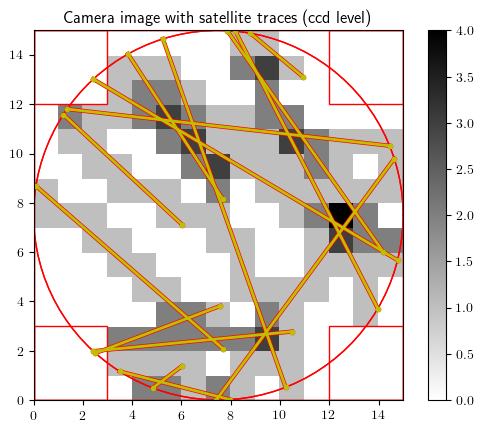

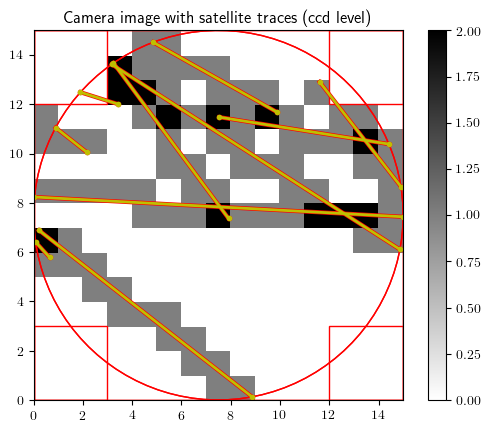

In [6]:
# The following is an example of "images" taken at same coordinates, at the same time, but with different random seed used to initialize the starlink constellation:
num_ccd1, perc_ccd1, traces_per_ccd1, ccd_id1, num_traces1, len_traces1, N_sat = get_image(observation_time_mjd, epoch, observation_az=150., observation_alt=20., sat_mult = 16, camera_mode='ccd', rnd_seed = 12345, plot_image=True)
num_ccd2, perc_ccd2, traces_per_ccd2, ccd_id2, num_traces2, len_traces2, _ = get_image(observation_time_mjd, epoch, observation_az=150., observation_alt=20., sat_mult = 16, camera_mode='ccd', rnd_seed = 54321, plot_image=True)
print(num_ccd1)
print(num_ccd2)

Usually we are not interested in one specific observation coordinate, but would like to analyze a wider part of the sky. One way to do so is to repetitively call get_image(...) with different input parameters (e.g. coordinates, trace width, random seed), but this is a slow way of doing it. 

Note that at the beginning of the function, we initialize the camera object, followed by the Observatory and the constellation (embedded into the Observatory initialization), all of which are expensive (in terms of runtime). To circumvent the issue, one should initialize camera and the observatory first, then loop over random seeds, trace widths and coordinates. Examples of such routines are provided in trace_utils module.

In [7]:
import trace_utils as tu
# define coordinates we want to observe
observations_az = np.array([150, 100, 200, 150 ])
observations_alt = np.array([20, 20, 20, 40])
# define trace widths we are interested in
trace_w = np.array([ 50, 100 ])
# set some random seeds
rnd_seed = np.array([123, 321])

# call the function
p_pix, p_ccd, num_traces, len_traces, N_sat = tu.get_images(observations_az, observations_alt, observation_time_mjd, epoch, traces_width = trace_w, sat_mult = 8, rnd_seed = rnd_seed)

# print results in a table format
from tabulate import tabulate
import sat_utils as su
from astropy.time import Time

o_time = Time(observation_time_mjd,format='mjd')  
# get "current" Sun position on the sky
sun_az, sun_alt, *_ = np.degrees(su.get_pos_Sun(observation_time_mjd))
T_avg = su.make_table('Results for rnd seed = 123', N_sat, trace_w, p_pix[:,:,0], p_ccd[:,0], num_traces[:,0], len_traces[:,0], o_time, sun_az, sun_alt,observations_az, observations_alt)
print (tabulate(T_avg,tablefmt="plain"))
T_avg = su.make_table('Results for rnd seed = 321', N_sat, trace_w, p_pix[:,:,1], p_ccd[:,1], num_traces[:,1], len_traces[:,1], o_time, sun_az, sun_alt,observations_az, observations_alt)
print (tabulate(T_avg,tablefmt="plain"))


Num satellites: 95416
Observation date/time: 2022-10-11 00:14:00.319
Sun az/alt: (250,-18)
##
Results for rnd seed = 123
##
camera data / (observation az/alt)              (150,20)  (100,20)  (200,20)  (150,40)
__________________________________
% pix (trace width = 50)                        0.19      0.0       0.3       0.05
% pix (trace width = 100)                       0.37      0.0       0.6       0.1
% ccd                                           22.75     0.0       25.4      5.82
num traces                                      6         0         5         3
length traces                                   0.14      0.0       0.2       0.03
Num satellites: 95416
Observation date/time: 2022-10-11 00:14:00.319
Sun az/alt: (250,-18)
##
Results for rnd seed = 321
##
camera data / (observation az/alt)              (150,20)  (100,20)  (200,20)  (150,40)
__________________________________
% pix (trace width = 50)                        0.23      0.0       0.53      0.15
% pix (trace w

In [8]:
# The following code finds the number of affected pixels and ccd's for altitudes in 10 degrees increment over the zenith, in the direction of Sun 

sat_multiplier = np.array([4,8])
tu.get_trace_info_fix_az_sun(sat_mult=sat_multiplier, traces_width=trace_w, rnd_seed=rnd_seed, observation_time_mjd=observation_time_mjd, epoch=epoch)


Num satellites: 47708
Observation date/time: 2022-10-11 00:14:00.319
Sun az/alt: (250,-18)
##
Sample mean
Num experiments: 2
##
camera data / (observation az/alt)              (250,20)  (250,30)  (250,40)  (250,50)  (250,60)  (250,70)  (250,80)  (250,90)  (70,80)  (70,70)  (70,60)  (70,50)  (70,40)  (70,30)  (70,20)
__________________________________
% pix (trace width = 50)                        0.06      0.02      0.02      0.04      0.03      0.04      0.05      0.0       0.04     0.08     0.0      0.04     0.0      0.0      0.0
% pix (trace width = 100)                       0.12      0.04      0.04      0.07      0.06      0.07      0.1       0.0       0.07     0.16     0.0      0.08     0.0      0.0      0.0
% ccd                                           7.67      2.65      3.7       3.44      3.97      5.56      5.56      0.0       5.56     10.58    0.0      5.03     0.0      0.0      0.0
num traces                                      2.0       0.5       1.5       0.5       1

In [9]:
# and the next takes "images" across the sky (0-360 degrees) for a fixed azimuth

#tu.get_trace_info_fix_alt(observation_alt=20, sat_mult=sat_multiplier, traces_width=trace_w, rnd_seed=rnd_seed, observation_time_mjd=observation_time_mjd, epoch=epoch)


The aforementioned trace_utils functions provide a way to save results in npz format. For more info and additional options check the implementation.

Information (and a plot) of all traces over the sky, given the number of satellites, observation time and exposure can be accomplished by a calling the following function:

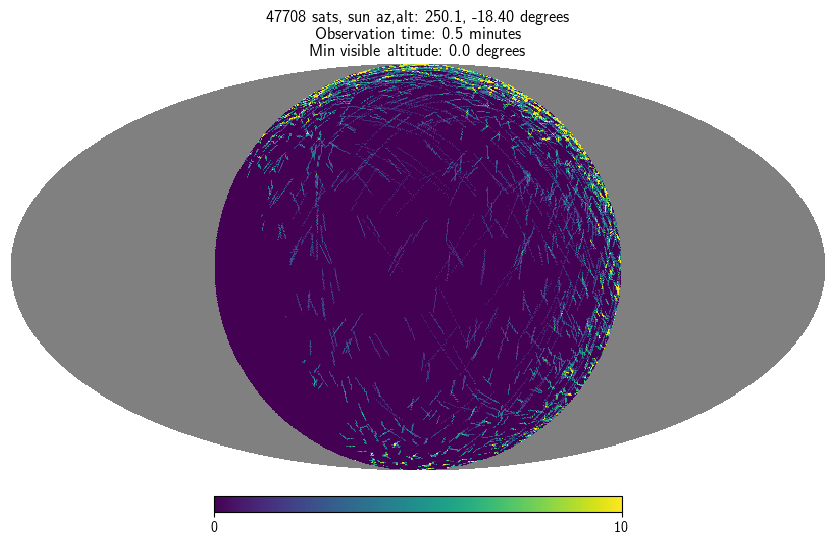

In [10]:
azimuth, altitudes, *_ = get_traces(observation_start_time_mjd=observation_time_mjd, epoch=epoch, observation_time_min=.5, sat_mult=4,  plot_image=True, max_mollview_col_range=10) 